In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.utils.tensorboard as tb
from Preprocessing.preprocessing import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [3]:
#static parameters
train_batch_size = 170
val_batch_size = 170
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [4]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [5]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [6]:
#network_output

In [7]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


In [8]:
# '''
# data is highly unbalanced
# # '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

In [9]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -117]
network_output = network_output[: -117]

print(network_input.shape)
print(network_output.shape)

torch.Size([8500, 50, 1])
torch.Size([8500])


In [10]:
#network_input[0]

In [11]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = 1, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size, num_layers = 1, batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x, hidden1, hidden2,batch_size):
        
        output, hidden1 = self.lstm1(x, hidden1)        
        #print(output.shape)
        
        output = self.dropout(output)
        
        output, hidden2 = self.lstm2(output, hidden2)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 38)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output, hidden2
    
    def hidden_init(self,batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden1 = (weight.new(1, batch_size, self.hidden_size).zero_().cuda(),
          weight.new(1, batch_size, self.hidden_size).zero_().cuda())
        
        hidden2 = (weight.new(1, batch_size, 38).zero_().cuda(),
          weight.new(1, batch_size, 38).zero_().cuda())
        return hidden1,hidden2

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [12]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [13]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [14]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [ ]:
#hidden = model.hidden_init(train_batch_size) 
#hidden

In [15]:
epochs = 500
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    
    hidden1, hidden2 = model.hidden_init(train_batch_size)    
    #print('hidden[0].shape:- ',hidden[0].shape)
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        #h = tuple([each.data for each in hidden])
        h1 = tuple([each.data for each in hidden1])
        h2 = tuple([each.data for each in hidden2])
        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output, h = model.forward(inputs, h1, h2, train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        #logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        val_h1 = tuple([each.data for each in hidden1])
        val_h2 = tuple([each.data for each in hidden2])
        
        output, hidden = model.forward(inputs, val_h1, val_h2,val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256_38.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.4000490 	Val Loss:3.0559365 	Train Acc: 7.970588% 	Val Acc: 11.4117651%
Validation Loss decreased from    inf to 3.055936, saving the model weights
Epoch: 1	Train Loss: 3.1698612 	Val Loss:2.9762021 	Train Acc: 8.529412% 	Val Acc: 11.4117651%
Validation Loss decreased from 3.055936 to 2.976202, saving the model weights
Epoch: 2	Train Loss: 3.1311081 	Val Loss:2.9635554 	Train Acc: 8.808824% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.976202 to 2.963555, saving the model weights
Epoch: 3	Train Loss: 3.1086993 	Val Loss:2.9558083 	Train Acc: 9.382353% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.963555 to 2.955808, saving the model weights
Epoch: 4	Train Loss: 3.1001165 	Val Loss:2.9525560 	Train Acc: 8.985294% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.955808 to 2.952556, saving the model weights
Epoch: 5	Train Loss: 3.0925640 	Val Loss:2.9494552 	Train Acc: 9.455883% 	Val Acc: 11.4117651%
Validation Loss decreased from 2.952556 to

Epoch: 54	Train Loss: 2.4304934 	Val Loss:2.3940889 	Train Acc: 18.33824% 	Val Acc: 15.2941181%
Epoch: 55	Train Loss: 2.4345036 	Val Loss:2.3882740 	Train Acc: 18.63235% 	Val Acc: 15.7058828%
Epoch: 56	Train Loss: 2.4228529 	Val Loss:2.4019753 	Train Acc: 19.07353% 	Val Acc: 15.1176474%
Epoch: 57	Train Loss: 2.4188706 	Val Loss:2.3827357 	Train Acc: 19.17647% 	Val Acc: 15.4117651%
Epoch: 58	Train Loss: 2.4248259 	Val Loss:2.3931638 	Train Acc: 18.98529% 	Val Acc: 15.4705887%
Epoch: 59	Train Loss: 2.4326602 	Val Loss:2.3939703 	Train Acc: 18.11765% 	Val Acc: 15.8235298%
Epoch: 60	Train Loss: 2.4114447 	Val Loss:2.3693580 	Train Acc: 19.26471% 	Val Acc: 16.6470592%
Validation Loss decreased from 2.378805 to 2.369358, saving the model weights
Epoch: 61	Train Loss: 2.4107700 	Val Loss:2.3849926 	Train Acc: 19.64706% 	Val Acc: 16.5882356%
Epoch: 62	Train Loss: 2.4065645 	Val Loss:2.3802968 	Train Acc: 19.66177% 	Val Acc: 17.1176475%
Epoch: 63	Train Loss: 2.4063226 	Val Loss:2.3931825 	Train

Epoch: 115	Train Loss: 2.1974439 	Val Loss:2.1343771 	Train Acc: 26.45588% 	Val Acc: 30.1176481%
Epoch: 116	Train Loss: 2.1713290 	Val Loss:2.1286201 	Train Acc: 27.75% 	Val Acc: 29.8823540%
Validation Loss decreased from 2.133946 to 2.128620, saving the model weights
Epoch: 117	Train Loss: 2.1668577 	Val Loss:2.1661314 	Train Acc: 27.80882% 	Val Acc: 25.7647066%
Epoch: 118	Train Loss: 2.2605281 	Val Loss:2.1595932 	Train Acc: 25.58824% 	Val Acc: 26.7058833%
Epoch: 119	Train Loss: 2.2003328 	Val Loss:2.1455364 	Train Acc: 26.41177% 	Val Acc: 29.1764717%
Epoch: 120	Train Loss: 2.1796994 	Val Loss:2.1078176 	Train Acc: 27.72059% 	Val Acc: 30.8235304%
Validation Loss decreased from 2.128620 to 2.107818, saving the model weights
Epoch: 121	Train Loss: 2.1572470 	Val Loss:2.1022468 	Train Acc: 28.02941% 	Val Acc: 31.0588245%
Validation Loss decreased from 2.107818 to 2.102247, saving the model weights
Epoch: 122	Train Loss: 2.1715047 	Val Loss:2.1123985 	Train Acc: 27.72059% 	Val Acc: 31.41

Epoch: 178	Train Loss: 1.6911992 	Val Loss:1.5788969 	Train Acc: 45.61765% 	Val Acc: 49.4705886%
Epoch: 179	Train Loss: 1.7049458 	Val Loss:1.5906754 	Train Acc: 44.0% 	Val Acc: 50.1764709%
Epoch: 180	Train Loss: 1.6977980 	Val Loss:1.5548712 	Train Acc: 44.23529% 	Val Acc: 52.2941184%
Epoch: 181	Train Loss: 1.6886170 	Val Loss:1.5412841 	Train Acc: 44.73529% 	Val Acc: 52.3529416%
Validation Loss decreased from 1.549196 to 1.541284, saving the model weights
Epoch: 182	Train Loss: 1.6833182 	Val Loss:1.5204603 	Train Acc: 45.16177% 	Val Acc: 52.2941187%
Validation Loss decreased from 1.541284 to 1.520460, saving the model weights
Epoch: 183	Train Loss: 1.6824629 	Val Loss:1.5230789 	Train Acc: 44.48529% 	Val Acc: 53.0588242%
Epoch: 184	Train Loss: 1.6593805 	Val Loss:1.4685029 	Train Acc: 45.89706% 	Val Acc: 53.5882363%
Validation Loss decreased from 1.520460 to 1.468503, saving the model weights
Epoch: 185	Train Loss: 1.6422966 	Val Loss:1.4582294 	Train Acc: 46.36765% 	Val Acc: 53.941

Epoch: 240	Train Loss: 1.1181034 	Val Loss:0.8613408 	Train Acc: 64.38235% 	Val Acc: 74.1176468%
Epoch: 241	Train Loss: 1.1320483 	Val Loss:0.9089491 	Train Acc: 63.30882% 	Val Acc: 72.1764708%
Epoch: 242	Train Loss: 1.0692608 	Val Loss:0.8681310 	Train Acc: 66.41177% 	Val Acc: 74.4705874%
Epoch: 243	Train Loss: 1.0249518 	Val Loss:0.8316382 	Train Acc: 67.61765% 	Val Acc: 75.2941173%
Epoch: 244	Train Loss: 1.0387921 	Val Loss:0.8811407 	Train Acc: 67.10294% 	Val Acc: 73.7647063%
Epoch: 245	Train Loss: 1.0038891 	Val Loss:0.7906848 	Train Acc: 68.0% 	Val Acc: 77.8235286%
Validation Loss decreased from 0.806467 to 0.790685, saving the model weights
Epoch: 246	Train Loss: 1.0287823 	Val Loss:1.0003546 	Train Acc: 67.08824% 	Val Acc: 69.5882350%
Epoch: 247	Train Loss: 1.0168363 	Val Loss:0.8162936 	Train Acc: 67.77941% 	Val Acc: 76.7647058%
Epoch: 248	Train Loss: 1.0033751 	Val Loss:0.7600625 	Train Acc: 68.39706% 	Val Acc: 78.0588239%
Validation Loss decreased from 0.790685 to 0.760062, 

Epoch: 308	Train Loss: 0.5735785 	Val Loss:0.3937229 	Train Acc: 81.67647% 	Val Acc: 88.5294110%
Epoch: 309	Train Loss: 0.5697362 	Val Loss:0.3677353 	Train Acc: 82.11765% 	Val Acc: 89.9411756%
Epoch: 310	Train Loss: 0.5465684 	Val Loss:0.3663172 	Train Acc: 82.67647% 	Val Acc: 90.0588232%
Epoch: 311	Train Loss: 0.5591593 	Val Loss:0.3041286 	Train Acc: 81.82353% 	Val Acc: 91.8823510%
Epoch: 312	Train Loss: 0.5725167 	Val Loss:0.3946509 	Train Acc: 82.05882% 	Val Acc: 87.8235292%
Epoch: 313	Train Loss: 0.5620019 	Val Loss:0.3933960 	Train Acc: 82.33823% 	Val Acc: 89.0588224%
Epoch: 314	Train Loss: 0.5339812 	Val Loss:0.3507890 	Train Acc: 83.07353% 	Val Acc: 90.5294114%
Epoch: 315	Train Loss: 0.5352818 	Val Loss:0.3133107 	Train Acc: 83.04412% 	Val Acc: 92.2352934%
Epoch: 316	Train Loss: 0.5293194 	Val Loss:0.2932958 	Train Acc: 83.63235% 	Val Acc: 92.5882351%
Epoch: 317	Train Loss: 0.5275598 	Val Loss:0.3143024 	Train Acc: 83.42647% 	Val Acc: 91.8235278%
Epoch: 318	Train Loss: 0.52400

Epoch: 377	Train Loss: 0.2937135 	Val Loss:0.0772119 	Train Acc: 90.77941% 	Val Acc: 98.4117627%
Epoch: 378	Train Loss: 0.2803327 	Val Loss:0.0662584 	Train Acc: 91.70588% 	Val Acc: 98.7058812%
Validation Loss decreased from 0.068207 to 0.066258, saving the model weights
Epoch: 379	Train Loss: 0.2903469 	Val Loss:0.0821125 	Train Acc: 90.92647% 	Val Acc: 98.2941163%
Epoch: 380	Train Loss: 0.2950115 	Val Loss:0.0976557 	Train Acc: 90.66176% 	Val Acc: 97.7647054%
Epoch: 381	Train Loss: 0.3162737 	Val Loss:0.0736185 	Train Acc: 90.20588% 	Val Acc: 98.7058806%
Epoch: 382	Train Loss: 0.3037619 	Val Loss:0.0724589 	Train Acc: 90.67647% 	Val Acc: 98.5882336%
Epoch: 383	Train Loss: 0.2711745 	Val Loss:0.0608888 	Train Acc: 91.76471% 	Val Acc: 98.7647051%
Validation Loss decreased from 0.066258 to 0.060889, saving the model weights
Epoch: 384	Train Loss: 0.2705927 	Val Loss:0.0559531 	Train Acc: 91.92647% 	Val Acc: 98.7058812%
Validation Loss decreased from 0.060889 to 0.055953, saving the mode

Epoch: 452	Train Loss: 0.1461499 	Val Loss:0.0244066 	Train Acc: 95.66176% 	Val Acc: 99.3529403%
Epoch: 453	Train Loss: 0.1531582 	Val Loss:0.0230362 	Train Acc: 95.29412% 	Val Acc: 99.3529403%
Validation Loss decreased from 0.023977 to 0.023036, saving the model weights
Epoch: 454	Train Loss: 0.1533784 	Val Loss:0.0272051 	Train Acc: 95.23529% 	Val Acc: 99.3529397%
Epoch: 455	Train Loss: 0.1613232 	Val Loss:0.0248017 	Train Acc: 95.0% 	Val Acc: 99.4117635%
Epoch: 456	Train Loss: 0.1502834 	Val Loss:0.0192170 	Train Acc: 95.5% 	Val Acc: 99.5882344%
Validation Loss decreased from 0.023036 to 0.019217, saving the model weights
Epoch: 457	Train Loss: 0.1412588 	Val Loss:0.0212054 	Train Acc: 95.88235% 	Val Acc: 99.4117635%
Epoch: 458	Train Loss: 0.1800799 	Val Loss:0.0268418 	Train Acc: 94.55882% 	Val Acc: 99.2941165%
Epoch: 459	Train Loss: 0.1692574 	Val Loss:0.0283794 	Train Acc: 94.75% 	Val Acc: 99.2941165%
Epoch: 460	Train Loss: 0.1516984 	Val Loss:0.0283722 	Train Acc: 95.42647% 	Val

Epoch: 531	Train Loss: 0.1734339 	Val Loss:0.0495225 	Train Acc: 94.91176% 	Val Acc: 98.7058812%
Epoch: 532	Train Loss: 0.2016378 	Val Loss:0.0241871 	Train Acc: 94.19118% 	Val Acc: 99.3529403%
Epoch: 533	Train Loss: 0.1663997 	Val Loss:0.0193841 	Train Acc: 94.63235% 	Val Acc: 99.4705880%
Epoch: 534	Train Loss: 0.1563156 	Val Loss:0.0180090 	Train Acc: 95.32353% 	Val Acc: 99.6470577%
Epoch: 535	Train Loss: 0.1419515 	Val Loss:0.0221576 	Train Acc: 95.64706% 	Val Acc: 99.3529403%
Epoch: 536	Train Loss: 0.1441956 	Val Loss:0.0167254 	Train Acc: 95.41176% 	Val Acc: 99.4705880%
Epoch: 537	Train Loss: 0.1340451 	Val Loss:0.0223833 	Train Acc: 96.02941% 	Val Acc: 99.2352927%
Epoch: 538	Train Loss: 0.1217507 	Val Loss:0.0223136 	Train Acc: 96.42647% 	Val Acc: 99.2941171%
Epoch: 539	Train Loss: 0.1075294 	Val Loss:0.0306872 	Train Acc: 96.98529% 	Val Acc: 99.2941171%
Epoch: 540	Train Loss: 0.1181329 	Val Loss:0.0143601 	Train Acc: 96.67647% 	Val Acc: 99.5294112%
Epoch: 541	Train Loss: 0.10222

KeyboardInterrupt: 

## MUSIC GENERATION

In [37]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256_38.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [52]:
#load population database
testing_data = np.ones(200)*1
# testing_data = list(range(50,90))
# testing_data.extend(testing_data[::-1])
# testing_data_rev = testing_data[::-1]
# testing_data_rev.extend(testing_data)
# testing_data = testing_data_rev


testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [46]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    list1[i]=(list1[i]-50)/(89-50)

list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [53]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    h1, h2 = test_model.hidden_init(test_batch_size)

    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
                
        test_hidden1 = tuple([each.data for each in h1])
        test_hidden2 = tuple([each.data for each in h2])
        
        test_output,_ = test_model.forward(test_slice, test_hidden1, test_hidden2, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [54]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number)

In [55]:
#predicted_notes_lst

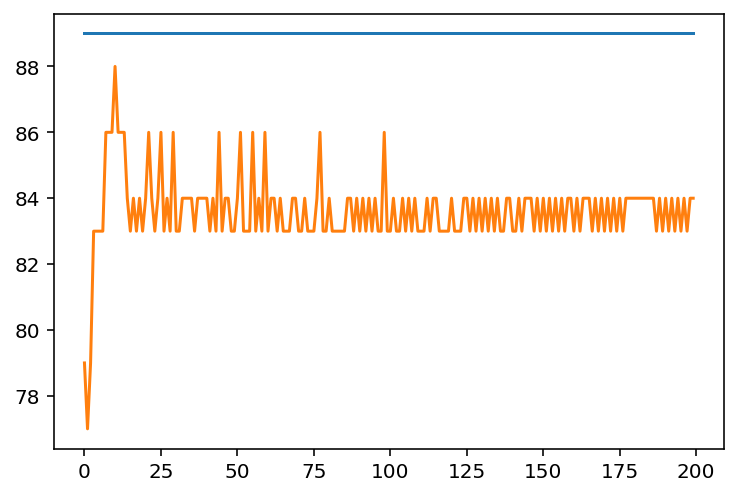

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(list(np.ones(200)*89))

#plt.plot(list(np.ones(200)*50))
#plt.plot(list(np.ones(20)*50))
#plt.plot(testing_data_unnorm)
plt.plot(predicted_notes_lst)

In [51]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({72: 1,
         77: 1,
         76: 4,
         81: 38,
         79: 15,
         83: 33,
         84: 50,
         69: 2,
         67: 1,
         74: 1,
         85: 7,
         86: 4,
         78: 3})

NameError: name 'X' is not defined